In [1]:
import sys
import numpy as np
sys.path.append('../')
from model import data_preparation as prep

# Get Some Data

In [2]:
con = prep.create_connection()
prepared_data = prep.prepare_data(con)

In [3]:
prepared_data
# Export script zu hdf5 file
#import deepdish as dd
#dd.io.save("20tanken.deepdish",prepared_data, compression=('blosc', 9))

{31: {'abahn': True,
  'brand': 'shell',
  'bstr': True,
  'county': '010010000000',
  'sstr': True,
  'state': 'schleswig-holstein',
  'time_series': {'test': array([1359, 1359, 1359, ..., 1409, 1489, 1489]),
   'train': array([1399, 1399, 1399, ..., 1359, 1359, 1359])}},
 75: {'abahn': False,
  'brand': 'aral',
  'bstr': True,
  'county': '01059',
  'sstr': False,
  'state': 'schleswig-holstein',
  'time_series': {'test': array([1339, 1339, 1339, ..., 1359, 1549, 1549]),
   'train': array([1379, 1379, 1379, ..., 1349, 1339, 1339])}},
 86: {'abahn': False,
  'brand': 'shell',
  'bstr': True,
  'county': '01054',
  'sstr': False,
  'state': 'schleswig-holstein',
  'time_series': {'test': array([1349, 1349, 1349, ..., 1419, 1489, 1489]),
   'train': array([1399, 1399, 1399, ..., 1349, 1349, 1349])}},
 123: {'abahn': False,
  'brand': 'aral',
  'bstr': True,
  'county': '01058',
  'sstr': False,
  'state': 'schleswig-holstein',
  'time_series': {'test': array([1349, 1349, 1349, ..., 1369

# Remove Trend
## with np.log

In [4]:
for key in prepared_data:
    prepared_data[key]["time_series"]["test"] = np.log(prepared_data[key]["time_series"]["test"].reshape(-1,1))
    prepared_data[key]["time_series"]["train"] = np.log(prepared_data[key]["time_series"]["train"].reshape(-1,1))
    

# using partial autocorelation

In [5]:
from statsmodels.tsa.stattools import pacf

keys = list(prepared_data.keys())

x_pacf=pacf( prepared_data[keys[0]]['time_series']['train'] , nlags =10, method='ols')

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [6]:
x_pacf # tells us one time lag correlates the most with 0.9

array([ 1.        ,  0.93284224, -0.1494532 , -0.05661209, -0.05656191,
       -0.03942817, -0.04061854,  0.00340488, -0.05484775,  0.20958867,
        0.08094779])

# Encode States numerical

In [7]:
def encodeState(data):
    states = {
     'baden-württemberg':1,
     'bayern':2,
     'berlin':3,
     'brandenburg':4,
     'bremen':5,
     'hamburg':6,
     'hessen':7,
     'mecklenburg-vorpommern':8,
     'niedersachsen':9,
     'nordrhein-westfalen':10,
     'rheinland-pfalz':11,
     'saarland':12,
     'sachsen':13,
     'sachsen-anhalt':14,
     'schleswig-holstein':15,
     'thüringen':16
    }
    data["state"] = states[data["state"]]
    return data


# Arrange Data to have List of training instances

In [8]:
x_train_adjusted = {}
x_test_adjusted = {}
y_train_adjusted = {}
y_test_adjusted = {}
for k in keys:
    prepared_data[k] = encodeState(prepared_data[k])
    x_train = prepared_data[k]["time_series"]["train"][0:-2]
    y_train_adjusted[k] = prepared_data[k]["time_series"]["train"][1:-1]
    x_test = prepared_data[k]["time_series"]["test"][0:-2]
    y_test_adjusted[k] = prepared_data[k]["time_series"]["test"][1:-1]
    x_train_adjusted[k] = []
    x_test_adjusted[k] = []
    for p in x_train:
        features = []
        features.append(np.float(p[0]))
        features.append(prepared_data[k]["state"])
        features.append(k)
        features.append(prepared_data[k]["county"])
        features.append(int(prepared_data[k]["abahn"]))
        features.append(int(prepared_data[k]["bstr"]))
        features.append(int(prepared_data[k]["sstr"]))
        x_train_adjusted[k].append(features)
    x_test_adjusted[k] = []
    for p in x_test:
        features = []
        features.append(np.float(p[0]))
        features.append(k)
        features.append(prepared_data[k]["state"])
        features.append(prepared_data[k]["county"])
        features.append(int(prepared_data[k]["abahn"]))
        features.append(int(prepared_data[k]["bstr"]))
        features.append(int(prepared_data[k]["sstr"]))
        x_test_adjusted[k].append(features)

In [9]:
x_train_adjusted =np.array([x_train_adjusted[k] for k in sorted(x_train_adjusted.keys())])
x_train_adjusted = x_train_adjusted.reshape(-1,7)
x_test_adjusted =np.array([x_test_adjusted[k] for k in sorted(x_test_adjusted.keys())])
x_test_adjusted = x_test_adjusted.reshape(-1,7)
y_test_adjusted =np.array([y_test_adjusted[k] for k in sorted(y_test_adjusted.keys())])
y_test_adjusted = y_test_adjusted.reshape(-1,1)
y_train_adjusted =np.array([y_train_adjusted[k] for k in sorted(y_train_adjusted.keys())])
y_train_adjusted = y_train_adjusted.reshape(-1,1)


# normalize price MinMax

In [10]:
maxValue =y_train_adjusted[:,0].max()
x_train_adjusted = x_train_adjusted.astype(float)
x_test_adjusted = x_test_adjusted.astype(float)
x_train_adjusted[:,0] *=1/maxValue
x_test_adjusted[:,0] *=1/maxValue
y_test_adjusted[:,0] *=1/maxValue
y_train_adjusted[:,0] *=1/maxValue

In [11]:
x_train_adjusted[0]

array([  9.60193831e-01,   1.50000000e+01,   3.10000000e+01,
         1.00100000e+10,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00])

In [12]:
#from keras.optimizers import SGD
#from keras.models import Sequential
#from keras.layers.core import Dense, Activation
#from keras.layers.recurrent import SimpleRNN, LSTM

In [13]:
#seed = 2016
#np.random.seed(seed)
#fit1 = Sequential()
#batch_size=50
##fit1.add(SimpleRNN(output_dim=8, activation="tanh", input_shape=(7, 1)))
#fit1.add(LSTM(30, return_sequences=True, stateful=True, input_shape=(7,1),batch_input_shape =(batch_size,7 ,1),inner_activation = 'hard_sigmoid',activation='sigmoid'))
#fit1.add(LSTM(50, stateful=True, return_sequences=True))
#fit1.add(LSTM(60, batch_input_shape=(batch_size, 7, 1), stateful=True))
#fit1.add(Dense(output_dim =1))
#fit1.compile(loss='mae', optimizer='adam')

In [14]:
x_train_adjusted = np.array(x_train_adjusted)
x_test_adjusted = np.array(x_test_adjusted)
x_train_adjusted = x_train_adjusted.reshape(x_train_adjusted.shape + (1, ))
x_test_adjusted = x_test_adjusted.reshape(x_test_adjusted.shape + (1, ))

In [15]:
#fit1.fit(x_train_adjusted, y_train_adjusted, batch_size=batch_size, epochs =2, shuffle = False )


In [16]:
#score_train = fit1.evaluate(x_train_adjusted, y_train_adjusted,batch_size=batch_size)
#score_test = fit1.evaluate (x_test_adjusted, y_test_adjusted,batch_size=batch_size)
#print("in train MAE = ", round( score_train, 6))
#print("in test MAE = ", round( score_test ,6))

In [17]:
#import matplotlib.pyplot as plt
#plt.plot(np.exp(y_test_adjusted[:10000]*maxValue)-np.exp(fit1.predict(x_test_adjusted[:10000])*maxValue))

#plt.plot(np.exp(y_test_adjusted*maxValue))
#plt.plot(np.exp(fit1.predict(x_test_adjusted,batch_size=batch_size)*maxValue))
#plt.show()

In [18]:
#from sklearn.neural_network import MLPRegressor
#import random

#create the model.
#regressor=MLPRegressor(hidden_layer_sizes=(5,5), activation='relu',  solver='sgd',shuffle=False,random_state=0)
#regressor.fit (x_train_adjusted.reshape(380500,7), y_train_adjusted.reshape(380500,1) )
#regressor.score(x_test_adjusted.reshape(95100,7) , y_test_adjusted.reshape(95100,1))


In [19]:
#plt.plot(np.exp(y_test_adjusted*maxValue))
#plt.plot(np.exp(regressor.predict(x_test_adjusted.reshape(95100,7))*maxValue))
#plt.show()

In [20]:
#from sklearn.model_selection import GridSearchCV
#mlp = MLPRegressor()
#param_grid = {'hidden_layer_sizes': [(i,i,i) for i in range(51,150)],
#              'activation': ['logistic'],
#              'solver': ['adam','sgd'],
#              'learning_rate': ['constant'],
#              'shuffle':[False],
#              'learning_rate_init': [0.001]}
#_GS = GridSearchCV(mlp, param_grid=param_grid, verbose=True, pre_dispatch='2*n_jobs')
#_GS.fit(x_train_adjusted.reshape(380500,7), y_train_adjusted.reshape(380500,1) )

In [21]:
#_GS.score(x_test_adjusted.reshape(380500,7), y_test_adjusted.reshape(380500,1) )

# fitting lasso regression model

seems to fit best our problem with a penalty value of 1e^-6

0.769675378023


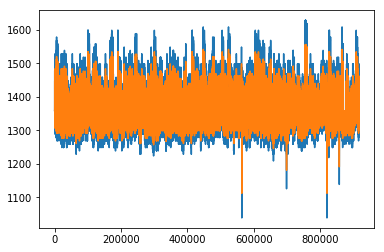

In [32]:
from sklearn import linear_model
import matplotlib.pyplot as plt
clf = linear_model.LassoLars(0.000001)
clf.fit (x_train_adjusted.reshape(3671825,7), y_train_adjusted.reshape(3671825,1) )
print(clf.score(x_test_adjusted.reshape(917715,7) , y_test_adjusted.reshape(917715,1)))

plt.plot(np.exp(y_test_adjusted*maxValue))
plt.plot(np.exp(clf.predict(x_test_adjusted.reshape(917715,7))*maxValue))
plt.show()

In [29]:
x_test_adjusted.shape

(917715, 7, 1)